In [1]:
from model.utils import timestep_embedding, timesteps_to_tensor
import torch.nn.functional as F
import math

from diffusion import DiffusionProcess
import torch
from diffusion.utils.sde import SDE
import numpy as np
import logging
from typing import Tuple

from pytorch_lightning import LightningDataModule
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import gridspec
import torch.nn as nn
from torch.distributions import Normal, Categorical, MixtureSameFamily, MultivariateNormal
from torch.utils.data import DataLoader, TensorDataset

# device = torch.device('mps') 
# device = 'cuda:0'
device = 'cpu'
import random
from src.PCF_with_empirical_measure import PCF_with_empirical_measure

# SDE-based diffusion models with ToyNet generator

In [2]:
class ResNet_FC(nn.Module):
    def __init__(self, data_dim, hidden_dim, num_res_blocks):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.map=nn.Linear(data_dim, hidden_dim)
        self.res_blocks = nn.ModuleList(
            [self.build_res_block() for _ in range(num_res_blocks)])

    def build_linear(self, in_features, out_features):
        linear = nn.Linear(in_features, out_features)
        return linear

    def build_res_block(self):
        hid = self.hidden_dim
        layers = []
        widths =[hid]*4  # [256, 256, 256, 256]
        for i in range(len(widths) - 1):
            layers.append(self.build_linear(widths[i], widths[i + 1]))
            layers.append(nn.SiLU())
        return nn.Sequential(*layers) # [batch_size, dim]

    def forward(self, x):  # x_t: [batch_size, data_dim]
        h=self.map(x)
        for res_block in self.res_blocks:
            h = (h + res_block(h)) / np.sqrt(2)
        return h   # [batch_size, dim]
    
    

In [3]:
class ToyNet(nn.Module):
    def __init__(self, data_dim, direction=None):
        super(ToyNet, self).__init__()
        self.direction = direction

        self.time_embed_dim = 128
        dim = 256
        out_dim = data_dim

        self.t_module = nn.Sequential(nn.Linear(self.time_embed_dim, dim), nn.SiLU(), nn.Linear(dim, dim),)
        self.x_module = ResNet_FC(data_dim, dim, num_res_blocks=1)
        self.out_module = nn.Sequential(nn.Linear(dim,dim), nn.SiLU(), nn.Linear(dim, out_dim),)
        
    def forward(self, x, t: int or list[int]): # x_t: [batch_size, data_dim]
        t = timesteps_to_tensor(t, batch_size=x.shape[0]).to(x.device)
        t_emb = timestep_embedding(t, self.time_embed_dim)  # [batch_size, time_embed_dim]

        t_out = self.t_module(t_emb) # [batch_size, dim=256]
        x_out = self.x_module(x) # [batch_size, dim=256]
        out   = self.out_module(x_out+t_out) # [batch_size, out_dim=data_dim]

        return out

In [4]:
class SDEProcess(DiffusionProcess):
    def __init__(self, sde_type="VP",
                 sde_info={"VP": {"beta_min": 0.1, "beta_max": 20},
                           "subVP": {"beta_min": 0.1, "beta_max": 20},
                           "VE": {"sigma_min": 0.01, "sigma_max": 50}}, 
                 **kwargs):
        super(SDEProcess, self).__init__(**kwargs)
        assert self.discrete is False, "DDPM is only for continuous data"
        self.dt = 1. / self.total_steps # step size
        self.sde = SDE(self.total_steps, sde_type, sde_info)
        
    def forward_one_step(self, x_prev, t):
        """
        Discretized forward SDE process for actual compuatation: 
        x_{t+1} = x_t + f_t(x_t) * dt + G_t * z_t * sqrt(dt)
        """
        f_t, g_t = self.sde.drifts(x_prev, t-1)
        z = torch.randn_like(x_prev)
        x_t = x_prev + f_t * self.dt + g_t * z * np.sqrt(self.dt)
        return x_t # [N]

    
    def backward_one_step(self, x_t, t, pred_score, clip_denoised=True):
        """
        Discretized backward SDE process for actual compuatation:
        x_{t-1} = x_t - (f_t(x_t) - (G_t)^2 * pred_score) * dt + G_t * z_t * sqrt(dt)
        """
        z = torch.randn_like(x_t).to(device) # [N,d=1]
        f_t, g_t = self.sde.drifts(x_t, t)
        f_t = f_t.to(device)
        x_prev = x_t - (f_t - g_t**2 * pred_score) * self.dt + g_t * z * np.sqrt(self.dt)
        if clip_denoised and x_t.ndim > 2:
            print('backward_one_step')
            x_prev.clamp_(-1., 1.) 

        return x_prev # [N,d=1]

    @torch.no_grad()
    def sample(self, noise, net):
        """
        Sample from backward diffusion process
        """
        x_t = noise # [N,1]
        trajs = [x_t]

        for t in reversed(range(1, self.total_steps+1)):
            pred_score = net(x_t, t)
            x_t = self.backward_one_step(x_t, t, pred_score)
            trajs.append(x_t)
        return x_t, torch.hstack(trajs)
    
    def forward_sample(self, data): # data: torch.tensor, shape=[N]
        trajs = torch.zeros([len(data), self.total_steps+1]) # [N, T+1]
        x = data.to(device) # [N]
        trajs[:, 0] = x
        for t in range(1, self.total_steps+1):
            x = self.forward_one_step(x, t) # [N]
            trajs[:, t] = x
        return x, trajs # [N], [N, T+1]
    
    def backward_sample(self, noise, net):
        """
        Sample from backward diffusion process
        """
        x_t = noise # [N,d=1]
        trajs = [x_t]

        for t in reversed(range(1, self.total_steps+1)):
            pred_score = net(x_t, t)
            x_t = self.backward_one_step(x_t, t, pred_score)
            trajs.append(x_t)
        return x_t, torch.hstack(trajs) # [N,d=1], [N,(T+1)*d]
        
    def backward_sample_example(self, noise, net):
        """
        Sample from backward diffusion process
        noise: torch.tensor, shape=[num_paths, T]
        """
        # noise_start = noise[:, 0]
        noise_end = noise[:, -1]
        # trajs = [noise_end]
        trajs = torch.zeros_like(noise)
        trajs[:, -1] = noise_end
        for t in reversed(range(1, self.total_steps+1)):
            pred_score = net(noise[:,t].unsqueeze(1), t) # [N,d=1]
            x_t = self.backward_one_step(noise[:,t].unsqueeze(1), t, pred_score)
            trajs[:,t-1] = x_t.squeeze()
        return x_t, trajs


In [5]:
# Data distribution
mix = Categorical(torch.ones(2,))
comp = Normal(torch.tensor([0 - 2., 0 + 2.]), torch.tensor([.5, .5]))
data_dist = MixtureSameFamily(mix, comp)



In [6]:
score_net = ToyNet(data_dim=1).to(device)
total_steps = 100
num_paths = 32
diffusion = SDEProcess(discrete=False, total_steps=total_steps, sde_type="VP")

In [7]:
def loss_function(x0, diffusion_process, score_net, t):
    #f_t is not involved in the score matching loss soe input zeros for the 1st argument.
    #
    _, g_t = diffusion_process.sde.drifts(torch.zeros_like(x0), t)
    
    # Eq 29 in Score based diffusion model (Yang Song 2021 ICLR)
    mean, std = diffusion_process.sde.perturbation_kernel(x0, t)
    z = torch.randn_like(x0)

    x_t = mean + std * z  # x_t is perturbed x_0
    pred_score = score_net(x_t, t)
    target = -z / std   # Since desired derivative of the given kernel is - (x_t - mean) / std^2
    loss = g_t**2 * F.mse_loss(pred_score, target, reduction="sum") / np.prod(x0.size())
    return loss

In [8]:
x_data = data_dist.sample([num_paths]).to(device)
x_noise, traj_forward = diffusion.forward_sample(x_data)

In [9]:
num_epochs = 2000
opt = torch.optim.Adam(score_net.parameters(), lr=1e-3)

for i in range(num_epochs):
    # Forward process to generate time series
    opt.zero_grad()
    x0 = data_dist.sample([num_paths]).to(device)
    t = np.random.randint(1, total_steps + 1)
    loss = loss_function(x0.view(-1 ,1), diffusion, score_net, t)
    loss.backward()
    opt.step()
    if(i%50==0):
        x0 = data_dist.sample([num_paths]).to(device)
        t = np.random.randint(1, total_steps + 1)
        loss = loss_function(x0.view(-1 ,1), diffusion, score_net, t)
        loss.backward()
        opt.step()
    if(i%50==0):
        print(i, loss)

0 tensor(12.2794, grad_fn=<DivBackward0>)
50 tensor(0.3696, grad_fn=<DivBackward0>)
100 tensor(0.1921, grad_fn=<DivBackward0>)
150 tensor(3.5364, grad_fn=<DivBackward0>)
200 tensor(0.0793, grad_fn=<DivBackward0>)
250 tensor(1.5969, grad_fn=<DivBackward0>)
300 tensor(0.7344, grad_fn=<DivBackward0>)
350 tensor(7.5403, grad_fn=<DivBackward0>)
400 tensor(0.6729, grad_fn=<DivBackward0>)
450 tensor(4.3409, grad_fn=<DivBackward0>)
500 tensor(4.5190, grad_fn=<DivBackward0>)
550 tensor(5.9239, grad_fn=<DivBackward0>)
600 tensor(2.7642, grad_fn=<DivBackward0>)
650 tensor(1.5213, grad_fn=<DivBackward0>)
700 tensor(5.8986, grad_fn=<DivBackward0>)
750 tensor(0.1847, grad_fn=<DivBackward0>)
800 tensor(27.3765, grad_fn=<DivBackward0>)
850 tensor(6.0631, grad_fn=<DivBackward0>)
900 tensor(7.4424, grad_fn=<DivBackward0>)
950 tensor(28.8315, grad_fn=<DivBackward0>)
1000 tensor(0.9606, grad_fn=<DivBackward0>)
1050 tensor(0.2138, grad_fn=<DivBackward0>)
1100 tensor(7.2351, grad_fn=<DivBackward0>)
1150 ten

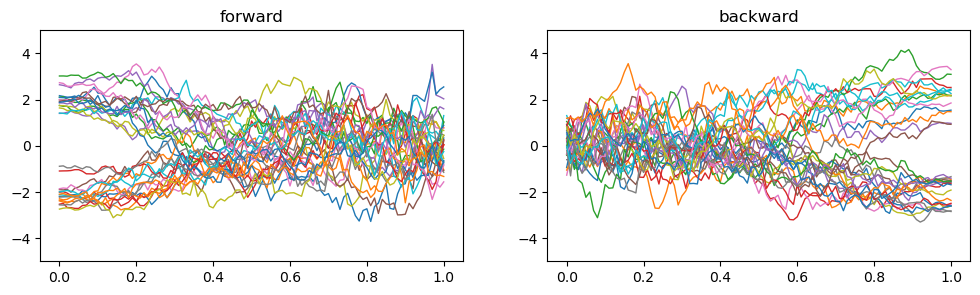

In [10]:
xxx = np.linspace(0, 1, traj_forward.shape[1])

plt.figure(figsize=(12,3))

plt.subplot(1, 2, 1)
for line in traj_forward:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('forward')
plt.ylim(-5, 5)
    
plt.subplot(1, 2, 2)
x_gen, traj_back = diffusion.sample(torch.randn([num_paths, 1]).to(device), score_net)
for line in traj_back:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('backward')
plt.ylim(-5, 5)

plt.show()

# ToyNet to predict score and local PCFD for discrimination

In [11]:
pcf = PCF_with_empirical_measure(8, 5, 1, add_time=True)
pcf = pcf.to(device)
num_paths = 64
G_opt = torch.optim.Adam(score_net.parameters(), lr=5e-4, betas=(0.9, 0.999))
D_opt = torch.optim.Adam(pcf.parameters(), lr=5e-3, betas=(0.9, 0.999))
n_Dstep_per_Gstep = 10
n_Gstep_per_Dstep = 1
t_max_step = 80

num_epochs = 5
ts_length = 20
forecast_length = 20

for i in range(num_epochs):
    x_data = data_dist.sample([num_paths]) # [N]
    x_noise, traj_forward = diffusion.forward_sample(x_data) # [N, total_steps+1]
    traj_forward = traj_forward.to(device) # [N, total_steps+1]
    traj_forward_flip = torch.fliplr(traj_forward)
             
    # train the PCF network as a discriminator. We want PCF has a great ablitily to distinguish the real data and the generated data. 
    # So we train the PCF to maxmise the distance between the real data and the generated data.
   
        #x_gen, traj_back = diffusion.backward_sample(torch.randn([num_paths, 1]).to(device), score_net)
        #x_gen, traj_back = diffusion.backward_sample(x_noise.to(device), score_net)

    for j in range(n_Gstep_per_Dstep):  
        with torch.no_grad():
            x_gen, traj_back = diffusion.backward_sample_example(traj_forward.to(device), score_net)
            t = torch.randint(t_max_step, (ts_length,))    
    
            x_real=traj_forward_flip.view([-1,total_steps+1, 1]) # [N, total_steps+1, 1]
            x_fake = traj_back.view([-1, total_steps+1, 1]) # [N, total_steps+1, 1]
        G_loss = 0
        for t1 in range(ts_length):
            G_loss = G_loss + pcf.distance_measure(x_real[:, [t1, t1+forecast_length]], 
                                x_fake[:, [t1,  t1+forecast_length]], Lambda=0.1) 
        G_loss = G_loss/ts_length
        G_opt.zero_grad()
        G_loss.backward()
        torch.nn.utils.clip_grad_norm_(score_net.parameters(), 0.05)

        G_opt.step()
        pcf.eval() 
        print(j,  G_loss.item())
        
    for j in range(n_Dstep_per_Gstep):
        with torch.no_grad():
            x_data = data_dist.sample([num_paths])
            x_noise, traj_forward = diffusion.forward_sample(x_data)
            traj_forward = traj_forward.to(device)
            x_gen, traj_back = diffusion.backward_sample(torch.randn([num_paths, 1]).to(device), score_net) 
        traj_forward_flip = torch.fliplr(traj_forward)
       # G_loss =  pcf.distance_measure(traj_forward_flip.view([-1, total_steps+1, 1]), 
                               # traj_back.view([-1, total_steps+1, 1]), Lambda=0) 
           
        x_real=traj_forward_flip.view([-1,total_steps+1, 1])
        x_fake = traj_back.view([-1, total_steps+1, 1])
        pcf.train()  # Set PCF model to training mode
    #D_loss = -pcf.distance_measure(traj_forward_flip.view([-1,  total_steps+1, 1]), 
                               # traj_back.view([-1, total_steps+1, 1]), Lambda=0.0) 
        t = torch.randint(t_max_step, (ts_length,)) 
        D_loss = 0
        for t1 in range(ts_length):
            D_loss = D_loss - pcf.distance_measure(x_real[:, [t1, t1+forecast_length]], 
                                x_fake[:, [t1,  t1+forecast_length]], Lambda=0.1) 
        D_loss =  D_loss/ts_length

        D_opt.zero_grad()
        D_loss.backward()
        D_opt.step()
        pcf.eval() 
        print(j, D_loss.item())
    


0 1.2894489765167236
0 -0.1063564270734787
1 -0.10724048316478729
2 -0.13541032373905182
3 -0.11329159885644913
4 -0.09741968661546707
5 -0.15167517960071564
6 -0.1900573968887329
7 -0.11836675554513931
8 -0.11872144788503647
9 -0.13912740349769592
0 0.9802892804145813
0 -0.1241932138800621
1 -0.10809894651174545
2 -0.1547849476337433
3 -0.12128697335720062
4 -0.12762698531150818
5 -0.08653794229030609
6 -0.12837105989456177
7 -0.14279834926128387
8 -0.1303536742925644
9 -0.15961530804634094
0 1.3411809206008911
0 -0.11884336173534393
1 -0.18980592489242554
2 -0.11587045341730118
3 -0.15275585651397705
4 -0.15439869463443756
5 -0.10669491440057755
6 -0.11061258614063263
7 -0.11904633045196533
8 -0.16802184283733368
9 -0.09050872921943665
0 1.1969802379608154
0 -0.12137355655431747
1 -0.2088325023651123
2 -0.12237106263637543
3 -0.1695910394191742
4 -0.1602638065814972
5 -0.20122258365154266
6 -0.14518192410469055
7 -0.15774010121822357
8 -0.19678956270217896
9 -0.20163781940937042
0 1.

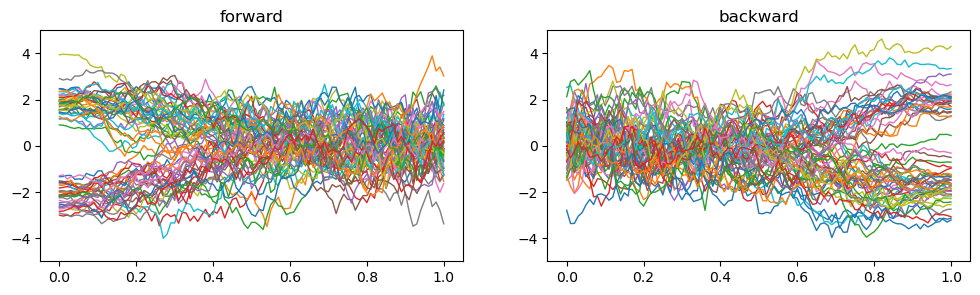

In [12]:
xxx = np.linspace(0, 1, traj_forward.shape[1])

plt.figure(figsize=(12,3))

plt.subplot(1, 2, 1)
for line in traj_forward:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('forward')
plt.ylim(-5, 5)
    
plt.subplot(1, 2, 2)
x_gen, traj_back = diffusion.sample(torch.randn([num_paths, 1]).to(device), score_net)


for line in traj_back:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('backward')
plt.ylim(-5, 5)

plt.show()

# local PCFD as loss function and SigRNN as generator

In [6]:
class FFN(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, hidden_dims: Tuple[int]):
      super().__init__()      
      blocks = []
      input_dim_block = input_dim

      for hidden_dim in hidden_dims:
          blocks.append(nn.Linear(input_dim_block, hidden_dim))
          blocks.append(nn.SiLU())
          input_dim_block = hidden_dim
      blocks.append(nn.Linear(input_dim_block, output_dim))
      self.network = nn.Sequential(*blocks)
      self.output_dim = output_dim

    def forward(self, x):
      out = self.network(x)
      return out
    


In [7]:
class BaseGenerator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(BaseGenerator, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, a=0.8, mode='fan_in', nonlinearity='leaky_relu')
                # nn.init.xavier_normal_(m.weight, gain=1.2, generator=None)
                # nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.normal_(m.bias, mean=0.01, std=0.01)
    
    def sample_eps(self, batch_size, input_dim, c_dt):
        """
        Generate i.i.d. Gaussian random variables with a defined covariance matrix.
        """
        cov_matrix = torch.tensor([[c_dt, (c_dt**2/2)],
                                   [(c_dt**2/2), (c_dt**3/3)]])     
        m = MultivariateNormal(loc=torch.zeros(2), covariance_matrix=cov_matrix)
        eps = m.sample((batch_size, input_dim))  # [N, input_dim, 2]
        return torch.reshape(eps, (batch_size, input_dim * 2))  # [N, 2*input_dim]
    
    def forward(self, *args, **kwargs):
        raise NotImplementedError("Forward pass should be implemented in derived class.")
    

In [8]:
class SigRNNDiffusion(DiffusionProcess):
    def __init__(self, sde_type="VP",
                 sde_info={"VP": {"beta_min": 0.1, "beta_max": 20},
                           "subVP": {"beta_min": 0.1, "beta_max": 20},
                           "VE": {"sigma_min": 0.01, "sigma_max": 50}},
                 ratio=4,
                 **kwargs):
        super(SigRNNDiffusion, self).__init__(**kwargs)
        assert self.discrete is False, "DDPM is only for continuous data"
        self.dt = 1. / self.total_steps # step size on fine time mesh
        self.ratio = ratio # number of steps on fine time mesh per step on coarse time mesh
        self.c_dt = ratio*self.dt # step size on coarse time mesh
        self.sde = SDE(self.total_steps, sde_type, sde_info)

    def forward_one_step(self, x_prev, t):
        """
        Discretized forward SDE process for actual compuatation:
        x_{t+1} = x_t + f_t(x_t) * dt + G_t * z_t * sqrt(dt)
        """
        f_t, g_t = self.sde.drifts(x_prev, t-1)
        z = torch.randn_like(x_prev)
        x_t = x_prev + f_t * self.dt + g_t * z * np.sqrt(self.dt)
        return x_t # [N]

    def forward_sample(self, data): # data: torch.tensor, shape=[N]
        trajs = torch.zeros([len(data), self.total_steps+1]) # [N,T+1]
        x = data.to(device) # [N]
        trajs[:, 0] = x
        for t in range(1, self.total_steps+1):
            x = self.forward_one_step(x, t) # [N]
            trajs[:, t] = x
        return x.unsqueeze(1), trajs # [N]->[N,d=1] the last, [N,T+1]


    def backward_one_coarse_step(self, x_t, starting_time, generator):
      x_prev = generator(x_t, starting_time, self.c_dt)
      return x_prev # [N,d=1]


    @torch.no_grad()
    def sample(self, x_t, tstart_index:int, forecast_csteps:int, generator):
      """
      Sample from backward diffusion process

      Arguments:
        x_t: the starting state randomly selected from fine time mesh
        tstart_index:int
        forecast_csteps: number of forcasting steps on the coarse time mesh
        generator: the generator model used to predict the previous state

      Returns:
        time_points: time points where the states are predicted
        x_t: the predicted ending state
        torch.hstack(trajs): [N,forecast_csteps+1] the starting state and all the predicted states
      """
      x_t = x_t.to(device) # [N,d=1]
      trajs = [x_t]
      starting_time = self.dt*tstart_index
      time_points = [tstart_index * self.dt]
      for t in range(forecast_csteps):
        x_t = self.backward_one_coarse_step(x_t, starting_time, generator)
        # x_t = self.backward_one_coarse_step(x_t, (tstart_index-t*self.ratio)*self.dt, generator) # [N,d=1]
        trajs.append(x_t)
        time_points.append( (tstart_index-(t+1)*self.ratio)*self.dt)
      return time_points, x_t, torch.hstack(trajs) # [N,d=1],  [N,(c_steps+1)*(d=1)]


    def backward_sample(self, x_t, tstart_index:int, forecast_csteps:int, generator):
      """
      Sample from backward diffusion process

      Arguments:
        x_t: the starting state randomly selected from fine time mesh
        tstart_index:int
        forecast_csteps: number of forcasting steps on the coarse time mesh
        generator: the generator model used to predict the previous state

      Returns:
        x_t: The predicted ending state
        torch.hstack(trajs): [N,forecast_csteps+1] the starting state and all the predicted states
      """
      x_t = x_t.to(device) # [N,d=1]
      trajs = [x_t] 
      starting_time = self.dt*tstart_index
      for t in range(forecast_csteps):
        x_t = self.backward_one_coarse_step(x_t, starting_time, generator)
        # x_t = self.backward_one_coarse_step(x_t, (tstart_index-t*self.ratio)*self.dt, generator) # [N,d=1]  
        trajs.append(x_t)
      return x_t, torch.hstack(trajs) # [N,d=1], [N,(c_steps+1)*(d=1)] 
    
    def backward_sample_example(self, x, tstart_index:int, forecast_csteps:int, generator):
      """
      Sample from backward diffusion process

      Arguments:
        x_t: the starting state randomly selected from fine time mesh
        tstart_index:int
        forecast_csteps: number of forcasting steps on the coarse time mesh
        generator: the generator model used to predict the previous state

      Returns:
        x_t: The predicted ending state
        torch.hstack(trajs): [N,forecast_csteps+1] the starting state and all the predicted states
      """
      x = x.to(device) # [N,d=1]
      trajs = [x[:, -1].unsqueeze(1)] # [N,1]
      starting_time = self.dt*tstart_index
      for t in range(forecast_csteps):
        x_t = self.backward_one_coarse_step(x[:,-t*self.ratio-1].unsqueeze(1), starting_time, generator)
        # x_t = self.backward_one_coarse_step(x_t, (tstart_index-t*self.ratio)*self.dt, generator) # [N,d=1]        x_t = self.backward_one_coarse_step(x_t, starting_time, generator) # [N,d=1]
        trajs.append(x_t)
      return x_t, torch.hstack(trajs) # [N,d=1], [N,(c_steps+1)*(d=1)]   



In [99]:
def init_weights(m):
  if isinstance(m, nn.Linear):
    # nn.init.kaiming_normal_(m.weight, a=1.3, mode='fan_in', nonlinearity='leaky_relu')
    nn.init.xavier_normal_(m.weight,gain=1.5)
    try:
      nn.init.zeros_(m.bias)
      # nn.init.normal_(m.bias,mean=0.,std=0.01)
    except:
      pass



In [100]:
class FNNGenerator(BaseGenerator):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(FNNGenerator, self).__init__(input_dim, hidden_dim, output_dim)        
        self.ffn = FFN(input_dim=2+3*input_dim, output_dim=output_dim, hidden_dims=[hidden_dim, hidden_dim])
        # self._initialize_weights()
        self.ffn.apply(init_weights)

    def forward(self, x_t, starting_point, c_dt):
        cdt_tensor = torch.tensor([c_dt]).unsqueeze(0).repeat(x_t.shape[0], 1).to(device)  # [N,1]
        t_tensor = torch.tensor([starting_point]).unsqueeze(0).repeat(x_t.shape[0], 1).to(device)  # [N,1]
        eps = self.sample_eps(batch_size=x_t.shape[0], input_dim=x_t.shape[1], c_dt=c_dt).to(device)  # [N, 2*d=2]
        out = x_t + self.ffn(torch.cat((t_tensor, x_t, cdt_tensor, eps), dim=1))  # [N, 1+3*input_dim]

        return out  # [N, output_dim=1]
    

class ResGenerator(BaseGenerator):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(ResGenerator, self).__init__(input_dim, hidden_dim, output_dim)    
        self.resnet = nn.Sequential(
            ResNet_FC(data_dim=2+3*input_dim, hidden_dim=hidden_dim, num_res_blocks=2),
            nn.SiLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        # self._initialize_weights()
        self.resnet.apply(init_weights)
        
    def forward(self, x_t, starting_point, c_dt):
        cdt_tensor = torch.tensor([c_dt]).unsqueeze(0).repeat(x_t.shape[0], 1).to(device)  # [N,1]
        t_tensor = torch.tensor([starting_point]).unsqueeze(0).repeat(x_t.shape[0], 1).to(device)  # [N,1]
        eps = self.sample_eps(batch_size=x_t.shape[0], input_dim=x_t.shape[1], c_dt=c_dt).to(device)  # [N, 2*d=2]
        out = x_t + self.resnet(torch.cat((t_tensor, x_t, cdt_tensor,eps), dim=1))  # [N, 1+3*input_dim]

        return out  # [N, output_dim=1]



Training the SigRNN-PCFD diffusion model

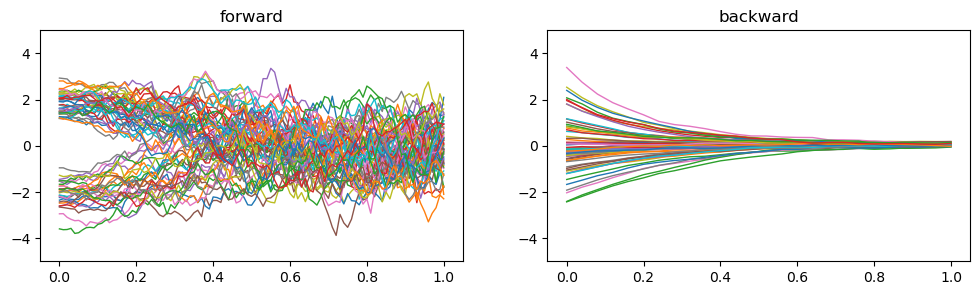

In [101]:
total_steps = 100
ratio = 4

pcf = PCF_with_empirical_measure(8, 5, 1, add_time=True)  # PCFD
pcf = pcf.to(device)

generator_fnn = FNNGenerator(input_dim=1, hidden_dim=256, output_dim=1).to(device)
diffusion = SigRNNDiffusion(discrete=False, total_steps=total_steps, sde_type="VP",ratio=ratio)
 
num_paths = 64
x_data = data_dist.sample([num_paths]).cpu()
x_noise, traj_forward = diffusion.forward_sample(x_data)
time_t = np.linspace(0, 1, traj_forward.shape[1])

plt.figure(figsize=(12,3))
plt.subplot(1, 2, 1)
for line in traj_forward:
    plt.plot(time_t, line.cpu(), linewidth=1.0)
    plt.title('forward')
plt.ylim(-5, 5)

plt.subplot(1, 2, 2)
time_points, x_gen, traj_back = diffusion.sample(torch.randn([num_paths, 1]).cpu(),
                                           tstart_index=total_steps,
                                           forecast_csteps=math.ceil(total_steps/ratio),
                                           generator=generator_fnn)
time_c = np.linspace(0, 1, traj_back.shape[1])
for line in traj_back:
    plt.plot(time_c, line.cpu(), linewidth=1.0)
    plt.title('backward')
plt.ylim(-5, 5)

plt.show()


In [102]:
batch_size = 64
num_epochs = 5
G_opt = torch.optim.Adam(generator_fnn.parameters(), lr=5e-4, betas=(0.99, 0.999))
D_opt = torch.optim.Adam(pcf.parameters(), lr=5e-3, betas=(0.99, 0.999))

n_Dstep_per_Gstep = 5
n_Gstep_per_Dstep = 5

ts_length = 10
forecast_csteps = 1

for i in range(num_epochs):
  x_data = data_dist.sample([batch_size])
  _, traj_forward = diffusion.forward_sample(x_data)
  traj_forward = traj_forward.to(device)

  # train the SigRNN Generator
  for j in range(n_Gstep_per_Dstep):
    ts = torch.randint(forecast_csteps*ratio,total_steps,(ts_length,))
    G_loss = 0
    for tstart_index in ts:
      tend_index = tstart_index-forecast_csteps*ratio
      # x_gen, traj_back = diffusion.backward_sample_example(traj_forward[:,tend_index:tstart_index+1:].to(device),
      #                                                             tstart_index=tstart_index,
      #                                                             forecast_csteps=forecast_csteps,
      #                                                             generator=generator_fnn)

      x_gen, traj_back = diffusion.backward_sample(traj_forward[:,tstart_index].unsqueeze(1).to(device),
                                                            tstart_index=tstart_index,
                                                            forecast_csteps=forecast_csteps,
                                                            generator=generator_fnn)
      traj_back = traj_back.to(device)
      x_real = torch.fliplr(traj_forward[:,tend_index:tstart_index+1:ratio]).view([-1, forecast_csteps+1, 1])
      x_fake = traj_back.view([-1, forecast_csteps+1, 1])
      G_loss = G_loss + pcf.distance_measure(x_real, x_fake, Lambda=0.1)

    G_loss = G_loss/ts_length
    G_opt.zero_grad()
    G_loss.backward()
    torch.nn.utils.clip_grad_norm_(generator_fnn.parameters(), 0.05)
    G_opt.step()
    pcf.eval()  
    print(j,  G_loss.item())

  # train the PCF network as a discriminator. We want PCF has a great ability to distinguish the real data and the generated data.
  # so we train the PCF to maximise the distance between the real data and the generated data.
  for j in range(n_Dstep_per_Gstep):
    ts = torch.randint(forecast_csteps*ratio,total_steps,(ts_length,))
    pcf.train()  # set PCF model to training mode
    D_loss = 0
    for tstart_index in ts:
      tend_index = tstart_index-forecast_csteps*ratio
      with torch.no_grad():
        x_gen, traj_back = diffusion.backward_sample(traj_forward[:,tstart_index].unsqueeze(1).to(device),
                                                          tstart_index=tstart_index,
                                                          forecast_csteps=forecast_csteps,
                                                          generator=generator_fnn)
      traj_back = traj_back.to(device)
      x_real = torch.fliplr(traj_forward[:,tend_index:tstart_index+1:ratio]).view([-1, forecast_csteps+1, 1])
      x_fake = traj_back.view([-1, forecast_csteps+1, 1])
      D_loss = D_loss - pcf.distance_measure(x_real, x_fake, Lambda=0.1)

    D_loss = D_loss/ts_length
    D_opt.zero_grad()
    D_loss.backward()
    D_opt.step()

    pcf.eval() 
    print(j, D_loss.item())
    


0 0.2533491849899292
1 0.1413520872592926
2 0.12550953030586243
3 0.1875794231891632
4 0.1584315299987793
0 -0.1520899534225464
1 -0.1863638162612915
2 -0.17148904502391815
3 -0.17010250687599182
4 -0.15111148357391357
0 0.21443772315979004
1 0.16415438055992126
2 0.17840322852134705
3 0.14333592355251312
4 0.17528624832630157
0 -0.19519972801208496
1 -0.2010297030210495
2 -0.1733199805021286
3 -0.18922898173332214
4 -0.13615277409553528
0 0.22295144200325012
1 0.20196962356567383
2 0.28385764360427856
3 0.2245694100856781
4 0.23166172206401825
0 -0.270050048828125
1 -0.29684674739837646
2 -0.27643221616744995
3 -0.2621021866798401
4 -0.2326478511095047
0 0.27842751145362854
1 0.2812887132167816
2 0.25602224469184875
3 0.23059682548046112
4 0.18722349405288696
0 -0.3390219807624817
1 -0.33887913823127747
2 -0.2155005931854248
3 -0.2827540636062622
4 -0.21816177666187286
0 0.2809985876083374
1 0.28586459159851074
2 0.25701168179512024
3 0.27295491099357605
4 0.18367917835712433
0 -0.221

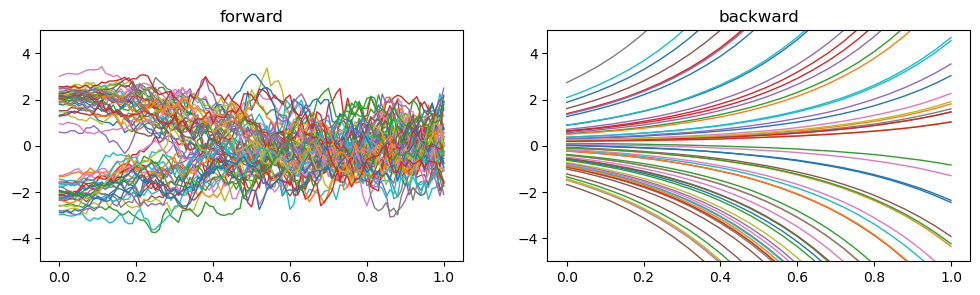

In [94]:
num_paths=64
x_data = data_dist.sample([num_paths]).cpu()
x_noise, traj_forward = diffusion.forward_sample(x_data)
time_t = np.linspace(0, 1, traj_forward.shape[1])

plt.figure(figsize=(12,3))
plt.subplot(1, 2, 1)
for line in traj_forward:
    plt.plot(time_t, line.cpu(), linewidth=1.0)
    plt.title('forward')
plt.ylim(-5, 5)

plt.subplot(1, 2, 2)
time_points, x_gen, traj_back = diffusion.sample(torch.randn([num_paths, 1]).cpu(),
                                           tstart_index=total_steps,
                                           forecast_csteps=math.ceil(total_steps/ratio),
                                           generator=generator_fnn)
time_c = np.linspace(0, 1, traj_back.shape[1])
for line in traj_back:
    plt.plot(time_c, line.cpu(), linewidth=1.0)
    plt.title('backward')
plt.ylim(-5, 5)

plt.show()

In [ ]:
batch_size = 64
num_epochs = 5
G_opt = torch.optim.Adam(generator_fnn.parameters(), lr=5e-4, betas=(0.99, 0.999))

D_opt = torch.optim.Adam(pcf.parameters(), lr=5e-3, betas=(0.99, 0.999))

n_Dstep_per_Gstep = 5
n_Gstep_per_Dstep = 5

ts_length = 10
forecast_csteps = 1

for i in range(num_epochs):
  x_data = data_dist.sample([batch_size])
  _, traj_forward = diffusion.forward_sample(x_data)
  traj_forward = traj_forward.to(device)

  for j in range(n_Dstep_per_Gstep):
    ts = torch.randint(forecast_csteps*ratio,total_steps,(ts_length,))
    pcf.train()
    D_loss = 0
    for tstart_index in ts:
      tend_index = tstart_index-forecast_csteps*ratio

      with torch.no_grad():
        x_gen, traj_back = diffusion.backward_sample(traj_forward[:,tstart_index].unsqueeze(1).to(device),
                                                          tstart_index=tstart_index,
                                                          forecast_csteps=forecast_csteps,
                                                          generator=generator_fnn)
      traj_back = traj_back.to(device)
      x_real = torch.fliplr(traj_forward[:,tend_index:tstart_index+1:ratio]).view([-1, forecast_csteps+1, 1])
      x_fake = traj_back.view([-1, forecast_csteps+1, 1])
      D_loss = D_loss - pcf.distance_measure(x_real, x_fake, Lambda=0.1)

    D_loss = D_loss/ts_length
    D_opt.zero_grad()
    D_loss.backward()
    D_opt.step()

    pcf.eval() 
    print(j, D_loss.item())
    

  for j in range(n_Gstep_per_Dstep):
    ts = torch.randint(forecast_csteps*ratio,total_steps,(ts_length,))
    G_loss = 0
    for tstart_index in ts:
      tend_index = tstart_index-forecast_csteps*ratio
      # x_gen, traj_back = diffusion.backward_sample_example(traj_forward[:,tend_index:tstart_index+1:].to(device),
      #                                                             tstart_index=tstart_index,
      #                                                             forecast_csteps=forecast_csteps,
      #                                                             generator=generator_fnn)
      x_gen, traj_back = diffusion.backward_sample(traj_forward[:,tstart_index].unsqueeze(1).to(device),
                                                            tstart_index=tstart_index,
                                                            forecast_csteps=forecast_csteps,
                                                            generator=generator_fnn)
      traj_back = traj_back.to(device)
      x_real = torch.fliplr(traj_forward[:,tend_index:tstart_index+1:ratio]).view([-1, forecast_csteps+1, 1])
      x_fake = traj_back.view([-1, forecast_csteps+1, 1])
      G_loss = G_loss + pcf.distance_measure(x_real, x_fake, Lambda=0.1)

    G_loss = G_loss/ts_length
    G_opt.zero_grad()
    G_loss.backward()
    torch.nn.utils.clip_grad_norm_(generator_fnn.parameters(), 0.05)
    G_opt.step()
    pcf.eval() 
    print(j,  G_loss.item())

0 -0.14376845955848694
1 -0.20048251748085022
2 -0.18366360664367676
3 -0.10633939504623413
4 -0.20691196620464325
0 0.14774252474308014
1 0.1313595473766327
2 0.15448734164237976
3 0.13297362625598907
4 0.18868473172187805
0 -0.11368192732334137
1 -0.22755758464336395
2 -0.13618138432502747
3 -0.12386773526668549
4 -0.15667948126792908
0 0.2013879120349884
1 0.1656116396188736
2 0.15303608775138855
3 0.15902535617351532
4 0.17510125041007996
0 -0.12879911065101624
1 -0.24325954914093018
2 -0.13400986790657043
3 -0.16101041436195374
4 -0.1663752794265747
0 0.18070535361766815
1 0.16863009333610535
2 0.20446482300758362
3 0.17927739024162292
4 0.20416243374347687
0 -0.2093091905117035
1 -0.2542092204093933
2 -0.262016236782074
3 -0.10196604579687119
4 -0.29416054487228394
0 0.24611766636371613
1 0.27200180292129517
2 0.2710098624229431
3 0.19741687178611755
4 0.1977674961090088
0 -0.1605215221643448
1 -0.19616910815238953
2 -0.17059767246246338
3 -0.2915511429309845
4 -0.212870746850967

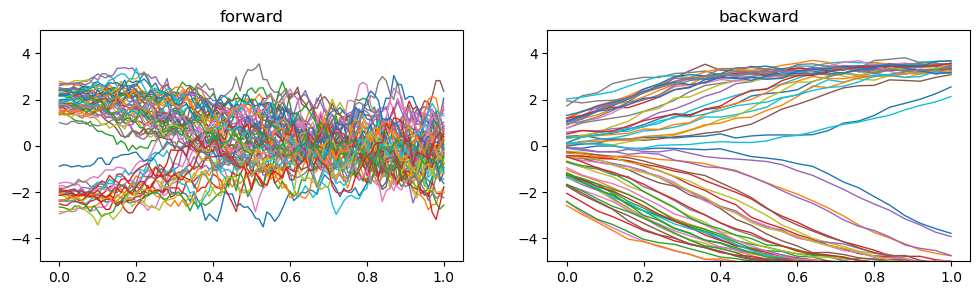

In [73]:
num_paths=64
x_data = data_dist.sample([num_paths]).cpu()
x_noise, traj_forward = diffusion.forward_sample(x_data)
time_t = np.linspace(0, 1, traj_forward.shape[1])

plt.figure(figsize=(12,3))
plt.subplot(1, 2, 1)
for line in traj_forward:
    plt.plot(time_t, line.cpu(), linewidth=1.0)
    plt.title('forward')
plt.ylim(-5, 5)

plt.subplot(1, 2, 2)
time_points, x_gen, traj_back = diffusion.sample(torch.randn([num_paths, 1]).cpu(),
                                           tstart_index=total_steps,
                                           forecast_csteps=math.ceil(total_steps/ratio),
                                           generator=generator_fnn)
time_c = np.linspace(0, 1, traj_back.shape[1])
for line in traj_back:
    plt.plot(time_c, line.cpu(), linewidth=1.0)
    plt.title('backward')
plt.ylim(-5, 5)

plt.show()


It looks that the current generator lacks ability, so we perform supervised learning on the backward process generator using L2 norm.

In [164]:
def train_model_supervised_l2(data_dist, generator, diffusion, batch_size=64, num_epochs=100,
                ts_length=None, forecast_csteps=1, lr=5e-4, betas=(0.9, 0.99), early_stopping_threshold=1e-5):
    G_opt = torch.optim.Adam(generator.parameters(), lr=lr, betas=betas)
    total_steps = diffusion.total_steps
    ratio = diffusion.ratio

    loss_history = [] 
    for epoch in range(num_epochs):
        generator.train()  
        x_data = data_dist.sample([batch_size])     
        _, traj_forward = diffusion.forward_sample(x_data)
        traj_forward = traj_forward.to(device)
        l2_loss = 0
        if ts_length is None:
            ts = torch.arange(forecast_csteps*ratio, total_steps+1).to(device)
            ts_length = len(ts)
        else:
            ts = torch.randint(forecast_csteps*ratio, total_steps, (ts_length,)).to(device)
        for tstart_index in ts:
            tend_index = tstart_index-forecast_csteps*ratio
            x_gen, traj_back = diffusion.backward_sample(traj_forward[:, tstart_index].unsqueeze(1).to(device),
                                                                tstart_index=tstart_index,
                                                                forecast_csteps=forecast_csteps,
                                                                generator=generator)
            traj_back = traj_back.to(device)
            x_real = torch.fliplr(traj_forward[:, tend_index:tstart_index+1:ratio]).view([-1, forecast_csteps+1, 1])
            x_fake = traj_back.view([-1, forecast_csteps+1, 1])
            l2_loss += F.mse_loss(x_real, x_fake) 
        l2_loss = l2_loss/ts_length
        G_opt.zero_grad()
        l2_loss.backward()
        G_opt.step()
        avg_loss = l2_loss.item()
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, L2 Loss: {avg_loss:.6f}")

        # early stopping
        if epoch > 5 and abs(loss_history[-1]-loss_history[-2]) < early_stopping_threshold:
            print("Loss has converged. Stopping training early.")
            break

    plt.plot(loss_history, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Trajectory')
    plt.legend()
    plt.show()
    return generator, loss_history

def test_model_sypervised(data_dist, trained_generator, diffusion, batch_size=64, forecast_csteps=1, ts_length=None):
    generator = trained_generator
    generator.eval()

    total_steps = diffusion.total_steps
    ratio = diffusion.ratio

    x_data = data_dist.sample([batch_size])   
    _, traj_forward = diffusion.forward_sample(x_data)
    traj_forward = traj_forward.to(device)

    l2_loss = 0.0
    if ts_length is None:
        ts = torch.arange(forecast_csteps*ratio, total_steps+1).to(device)
        ts_length = len(ts)
    else:            
        ts = torch.randint(forecast_csteps*ratio, total_steps, (ts_length,)).to(device)
    for tstart_index in ts:
        tend_index = tstart_index-forecast_csteps*ratio
        time_points, x_gen, traj_back = diffusion.sample(
            traj_forward[:, tstart_index].unsqueeze(1).to(device),
            tstart_index=tstart_index,
            forecast_csteps=forecast_csteps,
            generator=generator
        )
        traj_back = traj_back.to(device)
        x_real = torch.fliplr(traj_forward[:, tend_index:tstart_index+1:ratio]).view([-1, forecast_csteps+1, 1])
        x_fake = traj_back.view([-1, forecast_csteps+1, 1])
        l2_loss += F.mse_loss(x_real, x_fake)
    l2_loss = l2_loss/ts_length
    test_loss = l2_loss.item()
    print(f"Test Set L2 Loss: {test_loss:.6f}")

    time_t = np.linspace(0, 1, traj_forward.shape[1])
    plt.figure(figsize=(12,3))
    plt.subplot(1, 2, 1)
    for line in traj_forward:
        plt.plot(time_t, line.cpu(), linewidth=1.0)
        plt.title('forward')
    plt.ylim(-5, 5)

    plt.subplot(1, 2, 2)
    time_points, x_gen, traj_back = diffusion.sample(torch.randn([batch_size, 1]).cpu(),
                                            tstart_index=total_steps,
                                            forecast_csteps=math.ceil(total_steps/ratio),
                                            generator=generator)
    time_c = np.linspace(0, 1, traj_back.shape[1])
    for line in traj_back:
        plt.plot(time_c, line.cpu(), linewidth=1.0)
        plt.title('backward')
    plt.ylim(-5, 5)
    plt.show()



In [164]:
# Data distribution
# data_dist = Normal(loc=4,scale=1)
mix = Categorical(torch.ones(2,))
comp = Normal(torch.tensor([0 - 2., 0 + 2.]), torch.tensor([.5, .5]))
data_dist = MixtureSameFamily(mix, comp)


batch_size = 32
total_steps = 100
ratio = 4
num_epochs = 200
forecast_csteps = 1
ts_length=None
generator = FNNGenerator(input_dim=1, hidden_dim=64, output_dim=1).to(device)
diffusion = SigRNNDiffusion(discrete=False, total_steps=total_steps, sde_type="VP", ratio=ratio)

x_data = data_dist.sample([batch_size]).cpu()
x_noise, traj_forward = diffusion.forward_sample(x_data)
time_t = np.linspace(0, 1, traj_forward.shape[1])

plt.figure(figsize=(12,3))
plt.subplot(1, 2, 1)
for line in traj_forward:
    plt.plot(time_t, line.cpu(), linewidth=1.0)
    plt.title('forward')
plt.ylim(-5, 5)

plt.subplot(1, 2, 2)
time_points, x_gen, traj_back = diffusion.sample(torch.randn([batch_size, 1]).cpu(),
                                           tstart_index=total_steps,
                                           forecast_csteps=math.ceil(total_steps/ratio),
                                           generator=generator)
time_c = np.linspace(0, 1, traj_back.shape[1])
for line in traj_back:
    plt.plot(time_c, line.cpu(), linewidth=1.0)
    plt.title('backward')
plt.ylim(-5, 5)

plt.show()


In [ ]:
for name, param in generator.named_parameters():
    if 'weight' in name:
        # print(f"Name: {name}, Weight shape: {param.shape}")
        print(f"Initial weight values: {param.data}")
    elif 'bias' in name:
        print(f"Name: {name}, Bias shape: {param.shape}")
        # print(f"Initial bias values: {param.data}")

In [ ]:
trained_generator, loss_history = train_model_supervised_l2(data_dist=data_dist, generator=generator, diffusion=diffusion, 
                                                            batch_size=batch_size,num_epochs=num_epochs,
                                                            ts_length=None, forecast_csteps=forecast_csteps, lr=8e-3, 
                                                            betas=(0.9, 0.99), early_stopping_threshold=1e-5)
test_model_sypervised(data_dist=data_dist, 
                      trained_generator=trained_generator, diffusion=diffusion, 
                      batch_size=batch_size, forecast_csteps=forecast_csteps, ts_length=None)

